packages

In [9]:
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt


In [5]:
weather = pd.read_csv('weather.csv')
columns_to_drop = ['name', 'tempmax', 'tempmin', 'feelslikemin', 'feelslikemax', 'icon', 'stations']
weather.drop(columns_to_drop, axis=1, inplace=True)
weather

holid = pd.read_csv('holidays.csv')
#print(holid.head(5))

In [6]:
moon = pd.read_csv('full_moon.csv')

month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
    "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}
moon[['day', 'month', 'year']] = moon['FullMoonDates'].str.split(' ', expand=True)
moon['month'] = moon['month'].map(month_mapping)
moon['day'] = moon['day'].astype(int)
moon['year'] = moon['year'].astype(int)
moon


# Example string column
date_string = "25 January 2006"

date_object = datetime.strptime(date_string, '%d %B %Y')
date_object

datetime.datetime(2006, 1, 25, 0, 0)

In [7]:
os.chdir('..')
crime = pd.read_csv('Crimes.csv')


In [8]:
print(crime.head(1))
print(crime.tail(1))

         ID Case Number                    Date               Block  IUCR  \
0  13210072    JG422242  08/11/2023 11:00:00 AM  0000X S ALBANY AVE  1790   

                 Primary Type      Description Location Description  Arrest  \
0  OFFENSE INVOLVING CHILDREN  CHILD ABDUCTION            RESIDENCE   False   

   Domestic  ...  Ward  Community Area  FBI Code  X Coordinate Y Coordinate  \
0      True  ...  28.0            27.0        26     1155914.0    1899709.0   

   Year              Updated On   Latitude  Longitude  \
0  2023  09/16/2023 03:41:56 PM  41.880594 -87.702959   

                        Location  
0  (41.880594385, -87.702959421)  

[1 rows x 22 columns]
              ID Case Number                    Date                 Block  \
512186  13112389    JG307020  06/19/2023 10:17:00 AM  044XX W JACKSON BLVD   

        IUCR Primary Type                                        Description  \
512186  0453      BATTERY  AGGRAVATED POLICE OFFICER - OTHER DANGEROUS WE...   

 

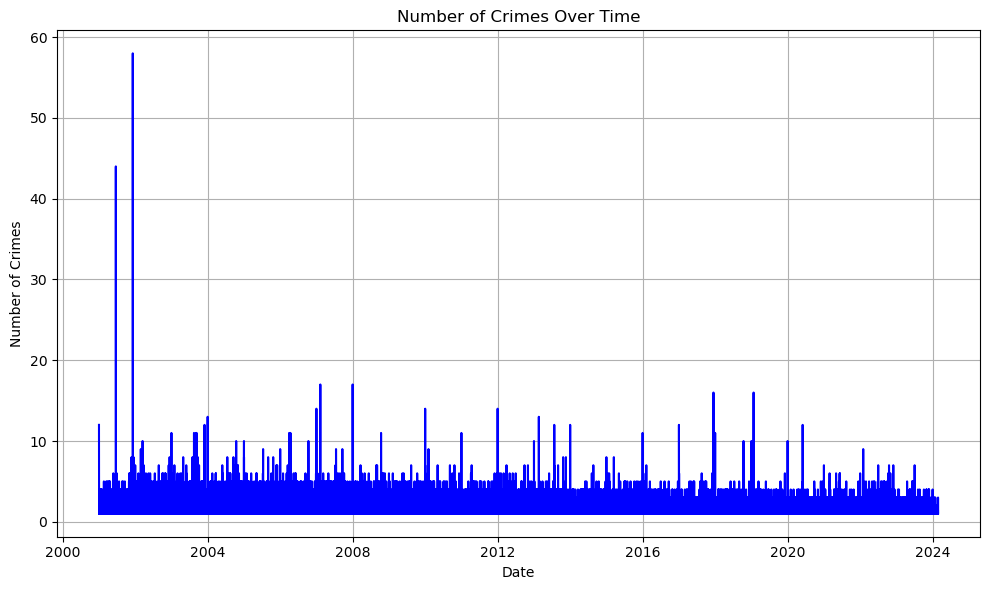

In [10]:
crime['Date'] = pd.to_datetime(crime['Date'])

# Group the data by date and count the number of crimes for each date
crime_count_by_date = crime.groupby('Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_date['Date'], crime_count_by_date['Crime Count'], color='blue')
plt.title('Number of Crimes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

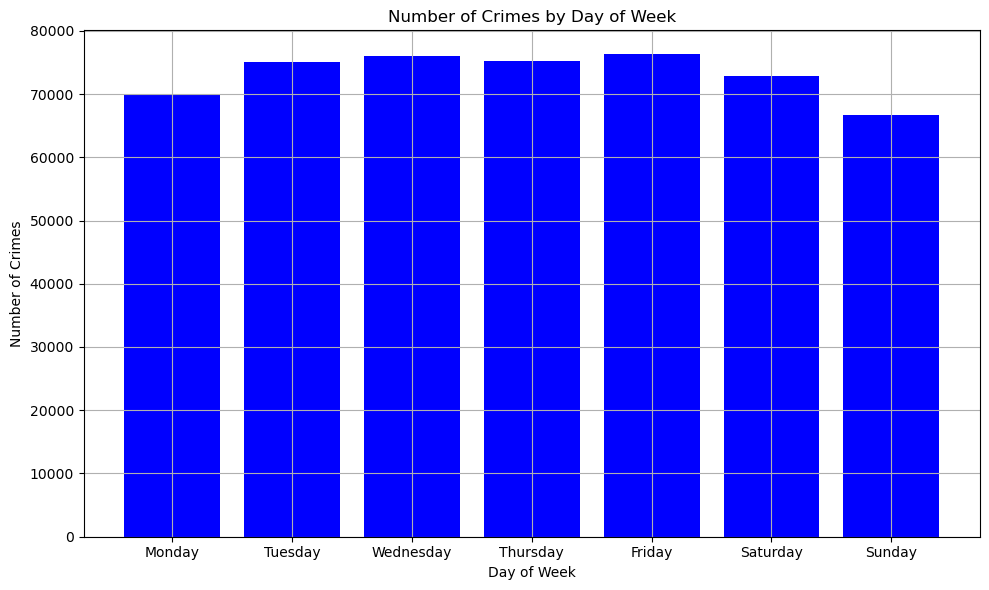

In [12]:
# Group the data by weekend vs weekday and count the number of crimes for each category
crime['DayOfWeek'] = crime['Date'].dt.day_name()
crime_count_by_day = crime.groupby('DayOfWeek').size().reset_index(name='Crime Count')
# Reindex the days of the week starting from Monday
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_count_by_day = crime_count_by_day.set_index('DayOfWeek').reindex(days_of_week).reset_index()

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.bar(crime_count_by_day['DayOfWeek'], crime_count_by_day['Crime Count'], color='blue')
plt.title('Number of Crimes by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

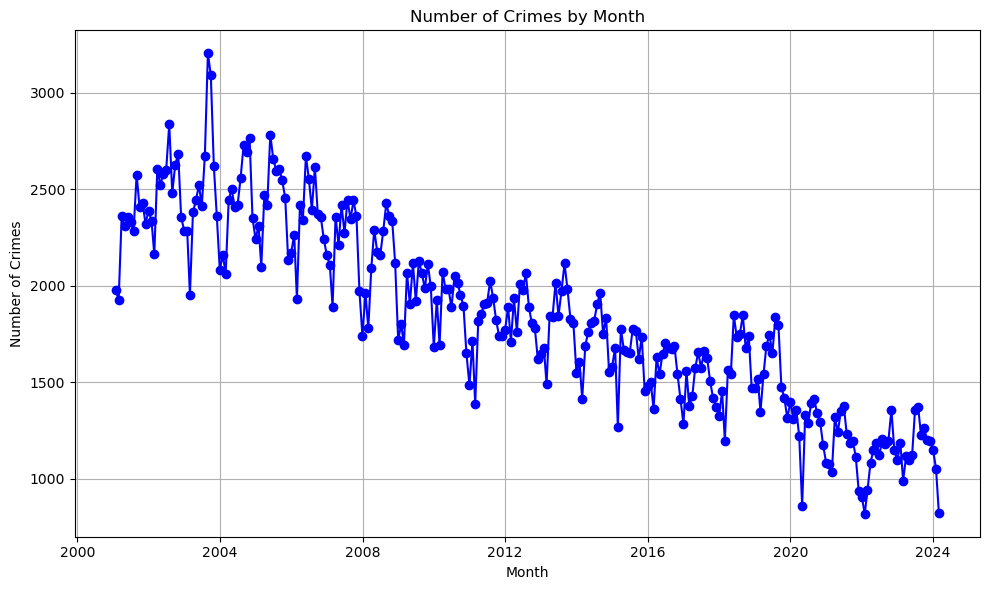

In [13]:
# Group the data by month and count the number of crimes for each month
crime_count_by_month = crime.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

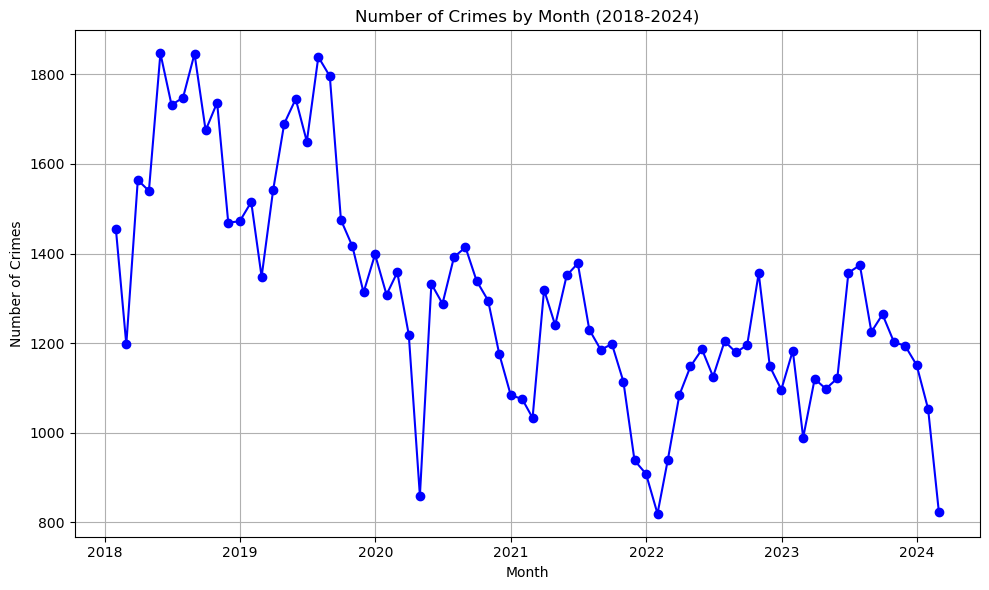

In [16]:
# Filter data for the range from 2010 to 2024
crime_df = crime[(crime['Date'].dt.year >= 2018) & (crime['Date'].dt.year <= 2024)]

# Group the filtered data by month and count the number of crimes for each month
crime_count_by_month = crime_df.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Crimes by Month (2018-2024)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Count occurrences of each type in the "Primary Type" column
primary_type_counts = crime['Primary Type'].value_counts()

# Sort the counts in descending order
primary_type_counts_sorted = primary_type_counts.sort_values(ascending=False)

# Print the sorted counts
print("Occurrences of each type in the 'Primary Type' column (sorted in descending order):")
print(primary_type_counts_sorted)

Occurrences of each type in the 'Primary Type' column (sorted in descending order):
Primary Type
NARCOTICS                            133988
BATTERY                              102071
THEFT                                 57756
CRIMINAL DAMAGE                       43168
ASSAULT                               32095
OTHER OFFENSE                         23849
ROBBERY                               22301
MOTOR VEHICLE THEFT                   21436
BURGLARY                              15266
DECEPTIVE PRACTICE                    12759
PROSTITUTION                          11309
WEAPONS VIOLATION                     10120
CRIMINAL TRESPASS                      9053
OFFENSE INVOLVING CHILDREN             2962
PUBLIC PEACE VIOLATION                 2877
GAMBLING                               2088
INTERFERENCE WITH PUBLIC OFFICER       2062
CRIM SEXUAL ASSAULT                    1613
HOMICIDE                               1398
SEX OFFENSE                            1267
ARSON                  

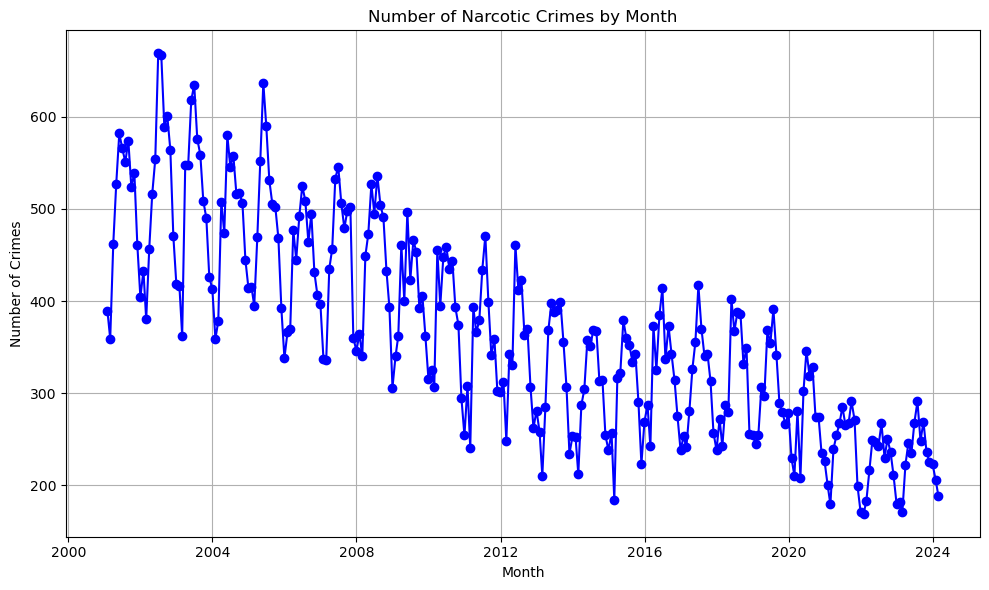

In [24]:
# Filter data for the narcotics
narcotics = crime[(crime['Primary Type'] == 'NARCOTICS')]

# Group the filtered data by month and count the number of crimes for each month
crime_count_by_month = narcotics.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Narcotic Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

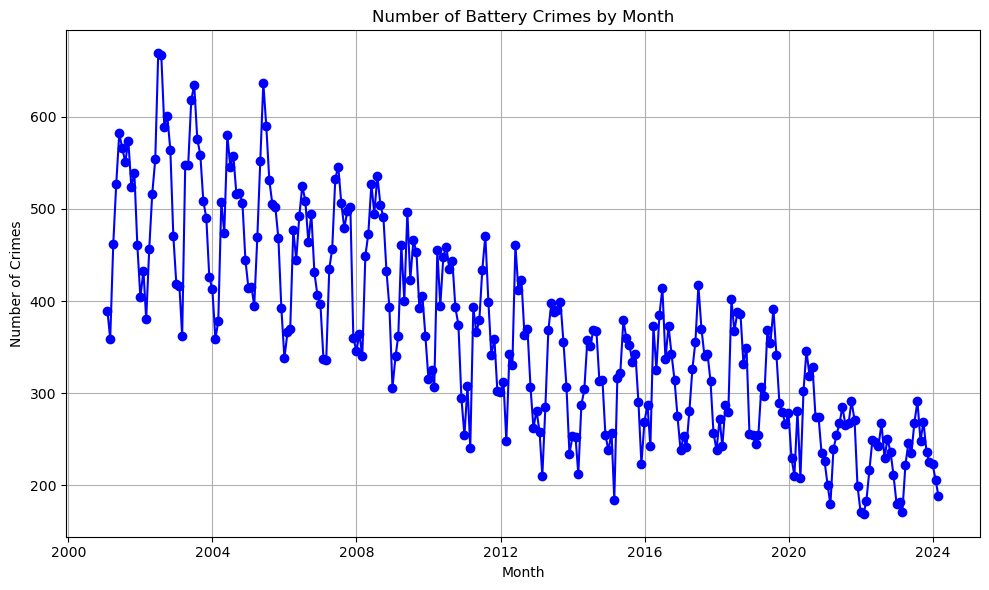

In [25]:
# Filter data for the narcotics
batter = crime[(crime['Primary Type'] == 'BATTERY')]

# Group the filtered data by month and count the number of crimes for each month
crime_count_by_month = batter.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Battery Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

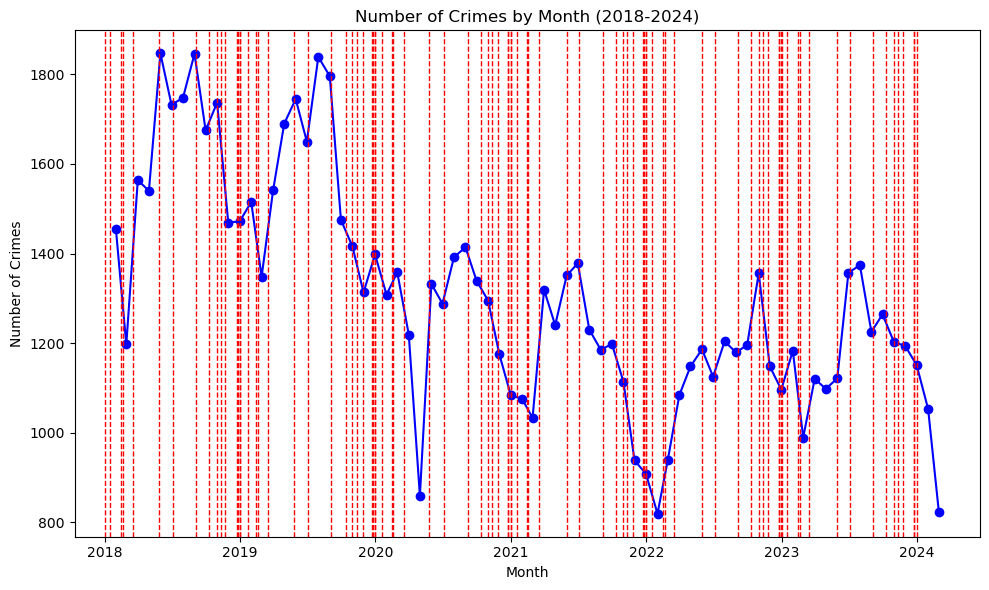

In [30]:
# Filter data for the range from 2010 to 2024
crime_df = crime[(crime['Date'].dt.year >= 2018) & (crime['Date'].dt.year <= 2024)]

# Group the filtered data by month and count the number of crimes for each month
crime_count_by_month = crime_df.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Crimes by Month (2018-2024)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')


# Iterate over each holiday and add a line to the plot
holid['Date'] = pd.to_datetime(holid['Date'])
holid_use = holid[(holid['Date'].dt.year >= 2018)]
for holiday_date in holid_use['Date']:
    plt.axvline(holiday_date, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


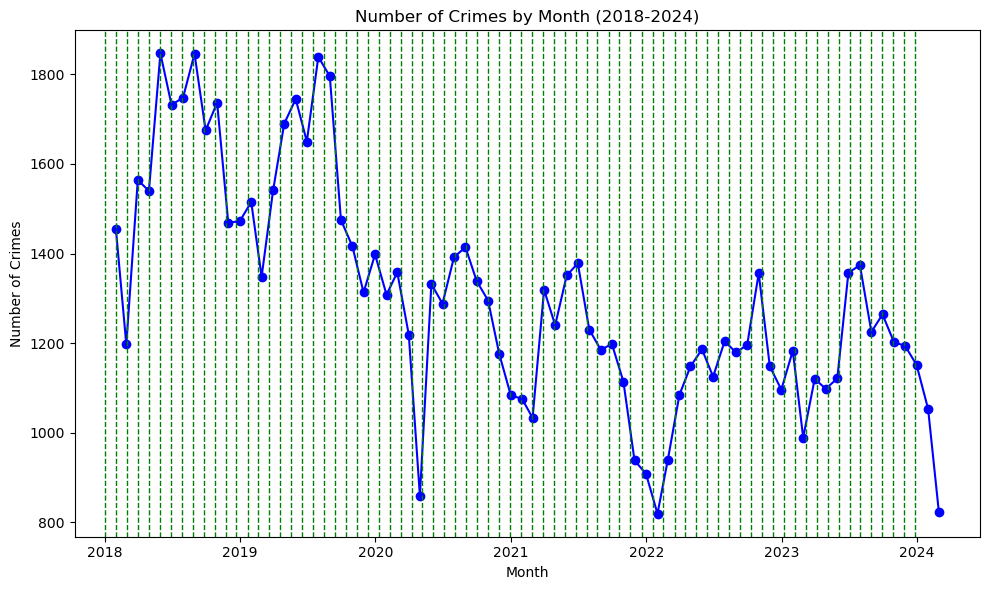

In [37]:
# Filter data for the range from 2010 to 2024
crime_df = crime[(crime['Date'].dt.year >= 2018) & (crime['Date'].dt.year <= 2024)]

# Group the filtered data by month and count the number of crimes for each month
crime_count_by_month = crime_df.resample('M', on='Date').size().reset_index(name='Crime Count')

# Plot the timeline
plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_month['Date'], crime_count_by_month['Crime Count'], marker='o', color='blue')
plt.title('Number of Crimes by Month (2018-2024)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')


# Iterate over each holiday and add a line to the plot
moon['FullMoonDates'] = pd.to_datetime(moon['FullMoonDates'])
moon_use = moon[(moon['FullMoonDates'].dt.year >= 2018)]
for moon_date in moon_use['FullMoonDates']:
    plt.axvline(moon_date, color='green', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [35]:
moon.iloc[:, 1].tolist()
moon.columns[1]
moon['FullMoonDates']

0        25 January 2005
1       24 February 2005
2          25 March 2005
3          24 April 2005
4            23 May 2005
             ...        
230       31 August 2023
231    29 September 2023
232      28 October 2023
233     27 November 2023
234     27 December 2023
Name: FullMoonDates, Length: 235, dtype: object